# Testing methods of Mishra et al. 2022

[link to paper](http://journals.sagepub.com/doi/10.1177/0272989X211044697)

**Note about dataset**

Measure of clinical utility is the standardized net benefit.

* $ R \equiv $ the risk threshold for recommending an intervention.
* $ \pi $ is the prevalence of the outcome
* $\text{TPR}_R \equiv$ the true positive rate when the model risk threshold is $R$. AKA the sensitivity or the hit rate.
* $\text{FPR}_R \equiv$ the same for the false positive rate. AKA 1 - specificity or the probability of a false alarm.
* The ratio $R/(1-R)$ represents the ratio of benefits and harms of recommending an intervention. In this case I would assume this means the benefits vs. harms of screening a patient.

$$ \text{sNB}_R = \text{TPR}_R - \frac{R}{1-R}\frac{1-\pi}{\pi} \text{FPR}_R$$

The advantage of this measure of clinical utility is that its maximum is 1 when the TPR=1 and FPR=0. It is an "opt-in" formulation that assumes the default should be not treating or screening the patient. Other measures of clinical utility include the net benefit and relative utility.

The behavior of the sNB is that as the risk becomes large, it penalizes a higher false positive rate. As the prevalence becomes higher, it penalizes false positives less. For the rare-disease case, we might expect that the risk is high of non-detection, but that the prevalence is somewhat low. So perhaps we want the threshold $R$ closer to 0 to indicate that the our threshold for screening is low.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

## Read and process the data set

To avoid duplicating the available data, you must download the data yourself and place it in the correct directory. Find the data at [this link](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008).

In [4]:
bc_data = load_breast_cancer()

In [5]:
print(bc_data['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [6]:
features = pd.DataFrame(data=bc_data.data, 
                  columns=bc_data.feature_names)

In [7]:
features_std = pd.DataFrame()

Scale the features to prepare for analysis

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
scaler = StandardScaler()

In [10]:
features_std = pd.DataFrame(data=scaler.fit_transform(features),\
                            columns=features.columns)

In [11]:
labels = pd.DataFrame(data=bc_data['target'], columns=['target'])

In [12]:
labels.value_counts()

target
1         357
0         212
dtype: int64

The labels indicate whether the case is malignant (0) or benign (1). 

In [13]:
old_malignant = features[labels['target'] == 0].index
old_benign = features[labels['target'] == 1].index

I don't like this labeling scheme so I'm going to flip the labels so benign is 0 and malignant is 1.

In [14]:
labels.iloc[old_malignant] = 1
labels.iloc[old_benign] = 0

In [15]:
labels.value_counts()

target
0         357
1         212
dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(\
                        features_std, labels, test_size=0.33,\
                                         random_state=42)

## Create artificial test sets with discrimination and calibration problems

Rather than randomly splitting the data set, I will split using an artificial criterion to create some difference between the training set patient population and the target set, because this toy dataset is a relatively easy classification problem. I intentionally want a performance drop (still need to define that quantitatively) in the held-out data here, so that I can "fix" it using different strategies.

### Fit a L1-regularized logistic regression model to the training data as-is

In [18]:
sagaseed = 12 # seed for optimization

In [19]:
clf = LogisticRegression(penalty='l1', tol=1e-4, C=1, fit_intercept=True,\
                                       random_state=sagaseed, solver='saga', max_iter=int(1e6));

In [20]:
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold

In [21]:
param_grid = {'C' : [1e-2,1e-1,1e0,1e1,1e2]}

In [22]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=sagaseed+1)

In [23]:
gridsearch = GridSearchCV(clf, param_grid, scoring='average_precision',\
                          cv=skf)

In [24]:
gridsearch.fit(x_train, y_train.to_numpy().ravel());

In [25]:
gridsearch.best_params_

{'C': 1.0}

In [26]:
clf.fit(x_train, y_train.to_numpy().ravel()); # the numpy/ravel stuff shuts up a warning

### Make a calibration curve for the naive classifier on the train and test data

In [27]:
from sklearn.calibration import calibration_curve

Note: below I'm selecting the probability of being malignant as the event of interest

In [28]:
y_train_pred = clf.predict_proba(x_train)[:,1]

In [29]:
y_test_pred = clf.predict_proba(x_test)[:,1]

In [39]:
xcal_train, ycal_train = calibration_curve(y_train, y_train_pred,n_bins=4)

In [40]:
xcal_test, ycal_test = calibration_curve(y_test, y_test_pred,n_bins=4)

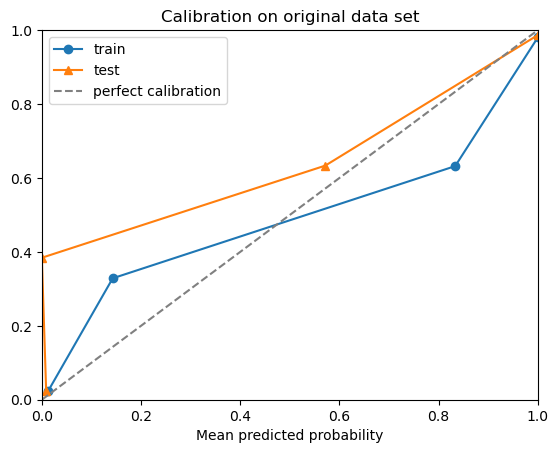

In [41]:
plt.plot(xcal_train, ycal_train,'o-', label='train')
plt.plot(xcal_test, ycal_test,'^-', label='test')
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1],'--',color='gray', label='perfect calibration')
plt.title('Calibration on original data set')
plt.xlabel('Mean predicted probability')
plt.legend();

It looks like the trained model is somewhat optimistic on the held out set

Predicted probabilities based on risk scores from logistic regression

In [33]:
risk_train = clf.intercept_ + x_train @ clf.coef_.T
risk_test  = clf.intercept_ + x_test @ clf.coef_.T

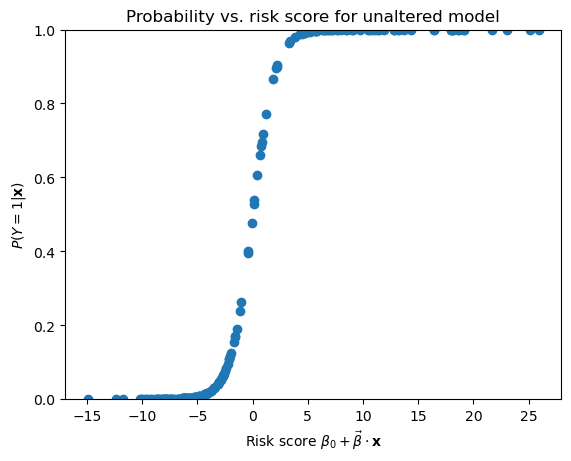

In [34]:
plt.plot(risk_test, y_test_pred, 'o')
plt.xlabel(r'Risk score $\beta_0 + \vec{\beta} \cdot \mathbf{x}$')
plt.ylabel(r'$P(Y=1|\mathbf{x})$')
plt.title('Probability vs. risk score for unaltered model')
plt.ylim(0,1);

## Making synthetic test data

The original logistic regression model is

$$ P(Y=1|\mathbf{x}) = \frac{1}{1+e^{-\beta_0 + \vec{\beta}\cdot\mathbf{x}}} $$

Let the risk score $z = \beta_0 + \vec{\beta_0}\cdot\mathbf{x}$

### Adding constant offset

What happens we adjust the probability by adding a constant offset $\alpha_0$ to the original risk score to generate synthetic data?

$$ P_1(Y=1|\mathbf{x}) = \frac{1}{1 + e^{-(\alpha_0 + z)}} $$

This will correspond to left and right translations of the probability vs. risk curve according to $\alpha_0$.

In [60]:
alpha0 = -2

In [61]:
y_test_synth_1 = 1./(1. + np.exp(-alpha0 - risk_test))

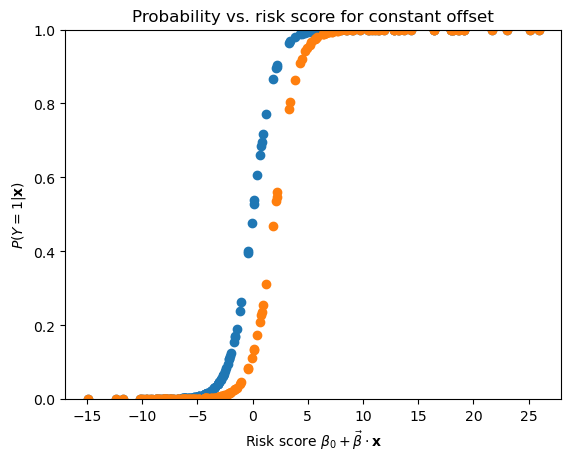

In [65]:
plt.plot(risk_test, y_test_pred, 'o')
plt.plot(risk_test, y_test_synth_1, 'o')
plt.xlabel(r'Risk score $\beta_0 + \vec{\beta} \cdot \mathbf{x}$')
plt.ylabel(r'$P(Y=1|\mathbf{x})$')
plt.title('Probability vs. risk score for constant offset')
plt.ylim(0,1);

### Adding multiplicative factor to $\vec{\beta}$

What happens we adjust the probability by adding a multiplicative factor $\alpha_1 > 0$ to the original risk score to generate synthetic data?

$$ P_1(Y=1|\mathbf{x}) = \frac{1}{1 + e^{-(\alpha_1 z)}} $$

This will correspond to making the probability curve more or less steep (more or less sharp transition)

In [73]:
alpha1 = 0.3

In [74]:
y_test_synth_2 = 1./(1. + np.exp(-alpha1*risk_test))

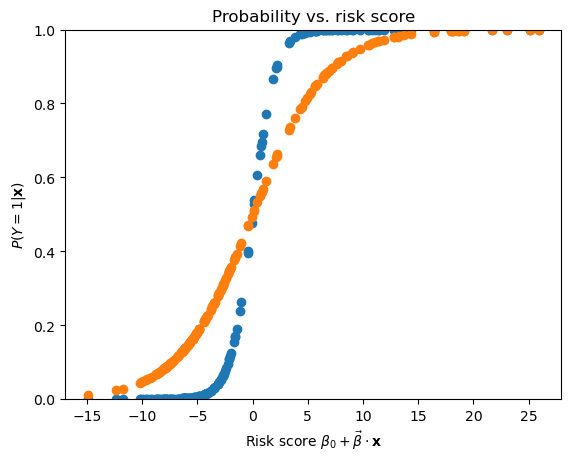

In [75]:
plt.plot(risk_test, y_test_pred, 'o')
#plt.plot(risk_test, y_test_synth_1, 'o')
plt.plot(risk_test, y_test_synth_2, 'o')
plt.xlabel(r'Risk score $\beta_0 + \vec{\beta} \cdot \mathbf{x}$')
plt.ylabel(r'$P(Y=1|\mathbf{x})$')
plt.title('Probability vs. risk score')
plt.ylim(0,1);